#**AI in Industry**

**Author**: Jyoti Yadav

**Date**: March 2022

**Email**: jyoti.yadav@studio.unibo.it

##Preliminary Steps

In [379]:
# The libraries we will use are imported here, in case of runtime problems

import sys 
import gzip
import os, shutil  #  file management
import pandas as pd  #  dataframe management
import numpy as np  #  data manipulation
import seaborn as sns
from urllib import request
from keras import regularizers
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from keras.layers import Input, Dense,Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc,roc_auc_score




LABELS = ["Normal","Anomly"]
random_state=2022

it is necessary, to clean all the data that are in the DATASETS directory and wipe out all the subdirectories.

In [380]:
folder = os.getcwd()

print("Current work directory: " + str(folder))
dataset_folder = os.path.join(os.getcwd(), "Datasets")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

for filename in os.listdir(dataset_folder):
    file_path = os.path.join(dataset_folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

print("Cleaned")

Current work directory: /content
Cleaned


##Dataset Download

In [381]:
# Config
print("Current work directory: {}".format(os.getcwd()))
dataset_folder = os.path.join(os.getcwd(), "Datasets")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = "https://github.com/jyotiyadav94/Ai-in-industry/raw/main/new_data/r205n13.gzip"

dataset_path = os.path.join(dataset_folder, "r205n12.gzip")

print(dataset_path)

def download_dataset(download_path: str, url: str):
    if not os.path.exists(download_path):
        print("Downloading dataset...")
        request.urlretrieve(url, download_path)
        print("Download complete!")


def extract_dataset(download_path: str, extract_path: str):
    data = pd.read_parquet('/content/Datasets/r205n12.gzip')
    print("Extraction completed!")
    return data

# Download
download_dataset(dataset_path, url)

#Extraction
df=extract_dataset(dataset_path, dataset_folder)


Current work directory: /content
/content/Datasets/r205n12.gzip
Download complete!
Extraction completed!


In [382]:
df.head(5)

,timestamp,avg:ambient,var:ambient,max:ambient,min:ambient,avg:dimm0_temp,var:dimm0_temp,max:dimm0_temp,min:dimm0_temp,avg:dimm10_temp,...,avg:swap_free,var:swap_free,max:swap_free,min:swap_free,avg:swap_total,var:swap_total,max:swap_total,min:swap_total,label,New_label
index,,,,,,,,,,,,,,,,,,,,,
13218,2020-07-16 19:30:00,23.493333,0.067810,23.8,23.0,29.133333,0.123810,30,29,31.6,...,4194240.0,0.0,4194240,4194240,4194240,0.0,4194240,4194240,0,2
13221,2020-07-16 19:45:00,25.573333,0.027810,25.8,25.4,30.800000,0.171429,31,30,33.0,...,4194240.0,0.0,4194240,4194240,4194240,0.0,4194240,4194240,0,2
13278,2020-07-17 00:30:00,21.569231,0.018974,21.8,21.4,27.000000,0.000000,27,27,31.0,...,4194240.0,0.0,4194240,4194240,4194240,0.0,4194240,4194240,0,0
13281,2020-07-17 00:45:00,21.600000,0.022857,21.8,21.4,27.000000,0.000000,27,27,31.0,...,4194240.0,0.0,4194240,4194240,4194240,0.0,4194240,4194240,0,0
13284,2020-07-17 01:00:00,21.280000,0.021714,21.4,21.0,27.000000,0.000000,27,27,31.0,...,4194240.0,0.0,4194240,4194240,4194240,0.0,4194240,4194240,0,0


## Data Analysis

In [383]:
df.isnull().values.any()

False

In [384]:
#finding the total missing values

missing_values = df.isnull().sum()
missing_per = (missing_values/df.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True) 
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)
missing_table

,Total Missing Values,Missing %
timestamp,0,0.0
avg:ambient,0,0.0
var:ambient,0,0.0
max:ambient,0,0.0
min:ambient,0,0.0
...,...,...
var:swap_total,0,0.0
max:swap_total,0,0.0
min:swap_total,0,0.0
label,0,0.0


In [385]:
#finding the unique number of labels in the dataset

print("No. of unique labels ", len(df['New_label'].unique()))
print("Label values ",df.New_label.unique())

No. of unique labels  2
Label values  [2 0]


In [386]:
#finding the count & percentage for each label 

data = df['New_label'].value_counts().to_frame().reset_index()
data['percent'] = data["New_label"].apply(lambda x : round(100*float(x) / len(df), 2))
data = data.rename(columns = {"index" : "Target", "New_label" : "Count"})
data

,Target,Count,percent
0,0,9197,92.14
1,2,785,7.86


## Imabalanced dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


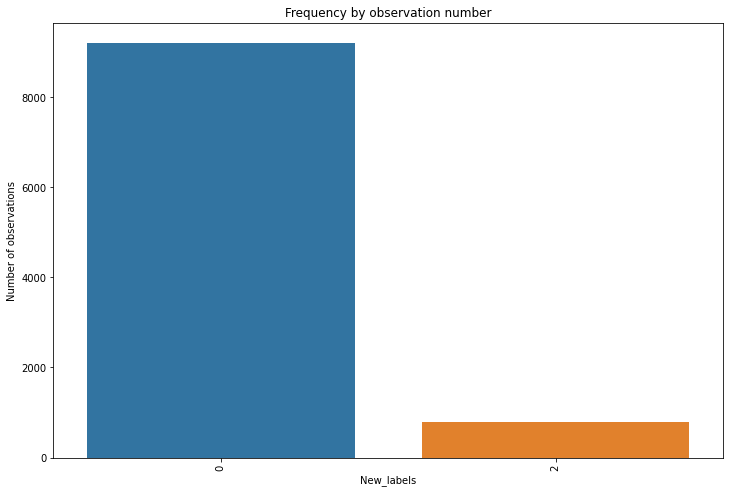

In [387]:
#visualizing both the New_label classes

countSet = df['New_label'].value_counts()
countSet

plt.figure(figsize=(12,8))
sns.barplot(countSet.index,countSet.values,)
plt.ylabel('Number of observations')
plt.xlabel('New_labels')
plt.title('Frequency by observation number')
plt.xticks(rotation='vertical')
plt.show()

In [388]:
#drop the label and timestamp as they are not required

df.drop('label', axis=1, inplace=True)
df.drop('timestamp', axis=1, inplace=True)

##Train Test Split

In [389]:
#train test split with 80% training and 20% testing

X_train, X_test = train_test_split(df,test_size = 0.2,random_state=2022)

In [390]:
#training the model with only Normal transactions and keeping only the normal transactions and making features from normal transactions
X_train=X_train[X_train.New_label==0]
X_train = X_train.drop(['New_label'], axis=1) 
y_test = X_test['New_label']
X_test = X_test.drop(['New_label'], axis=1)

In [391]:
X_test

,avg:ambient,var:ambient,max:ambient,min:ambient,avg:dimm0_temp,var:dimm0_temp,max:dimm0_temp,min:dimm0_temp,avg:dimm10_temp,var:dimm10_temp,...,max:proc_total,min:proc_total,avg:swap_free,var:swap_free,max:swap_free,min:swap_free,avg:swap_total,var:swap_total,max:swap_total,min:swap_total
index,,,,,,,,,,,,,,,,,,,,,
42219,21.933333,0.009524,22.0,21.8,29.000000,0.000000,29,29,30.0,0.0,...,1719,1717,3506432.0,0.0,3506432,3506432,4194240,0.0,4194240,4194240
47607,19.560000,0.012571,19.8,19.4,25.066667,0.066667,26,25,29.0,0.0,...,1718,1717,3578112.0,0.0,3578112,3578112,4194240,0.0,4194240,4194240
89724,23.600000,0.000000,23.6,23.6,31.000000,0.000000,31,31,32.0,0.0,...,1738,1732,4194240.0,0.0,4194240,4194240,4194240,0.0,4194240,4194240
89253,23.200000,0.000000,23.2,23.2,30.000000,0.000000,30,30,31.0,0.0,...,1738,1733,4194240.0,0.0,4194240,4194240,4194240,0.0,4194240,4194240
69321,23.893333,0.010667,24.0,23.8,31.000000,0.000000,31,31,32.0,0.0,...,1847,1845,3741696.0,0.0,3741696,3741696,4194240,0.0,4194240,4194240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90360,24.386667,0.002667,24.4,24.2,31.000000,0.000000,31,31,32.0,0.0,...,1739,1731,4194240.0,0.0,4194240,4194240,4194240,0.0,4194240,4194240
44169,21.800000,0.000000,21.8,21.8,29.000000,0.000000,29,29,30.0,0.0,...,1720,1718,3553536.0,0.0,3553536,3553536,4194240,0.0,4194240,4194240
14160,25.160000,0.046857,25.4,24.8,30.066667,0.066667,31,30,33.0,0.0,...,1649,1643,4194240.0,0.0,4194240,4194240,4194240,0.0,4194240,4194240


##Minmax Scaling

In [392]:
#performing minmax scaling on dataframe X_train,X_test & y_test

normalizer = preprocessing.MinMaxScaler(feature_range=(0, 1))
normalized_train_X = pd.DataFrame(normalizer.fit_transform(X_train),  columns = X_train.columns)
normalized_test_X = pd.DataFrame(normalizer.fit_transform(X_test),  columns = X_test.columns)
normalized_test_y=normalizer.fit_transform(y_test.values.reshape(-1,1))

#converting the 2d array to 1d flattened array
y_test_=normalized_test_y.ravel()

In [393]:
normalized_test_y

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

## Autoencoder

In [394]:
#providing the parameters for the autoencoder model

input_dim=normalized_train_X.shape[1]
print('input_dim',input_dim)
encoding_dim=230
print('encoding_dim',encoding_dim)
hidden_dim_1 = int(encoding_dim / 2)
print('hidden_dim_1',hidden_dim_1)
hidden_dim_2=60
print('hidden_dim_2',hidden_dim_2)
epoch=100
batch_size=32
learning_rate = 1e-5

input_dim 460
encoding_dim 230
hidden_dim_1 115
hidden_dim_2 60


In [395]:
#Implementation of autoencoder model

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l2(learning_rate))(input_layer)
encoder=Dropout(0.2)(encoder)
encoder =Dense(hidden_dim_1, activation='relu')(encoder)
# encoder=Dropout(0.2)(encoder)
encoder = Dense(hidden_dim_2, activation="tanh")(encoder)


decoder = Dense(hidden_dim_1, activation='relu')(encoder)
decoder=Dropout(0.2)(decoder)
decoder = Dense(encoding_dim, activation='tanh')(decoder)
# decoder=Dropout(0.2)(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 460)]             0         
                                                                 
 dense_78 (Dense)            (None, 230)               106030    
                                                                 
 dropout_26 (Dropout)        (None, 230)               0         
                                                                 
 dense_79 (Dense)            (None, 115)               26565     
                                                                 
 dense_80 (Dense)            (None, 60)                6960      
                                                                 
 dense_81 (Dense)            (None, 115)               7015      
                                                                 
 dropout_27 (Dropout)        (None, 115)               0  

In [396]:
#Early stopping
early_stop = EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=10,verbose=1, mode='min',restore_best_weights=True)
autoencoder.compile(loss='mean_squared_error', optimizer='SGD')

# start_time = time.time()
history = autoencoder.fit(normalized_train_X, normalized_train_X, epochs=epoch, batch_size=batch_size,shuffle=True,validation_data=(normalized_test_X, normalized_test_X),verbose=1).history
# end_time = time.time()
# print('Time Taken',end_time-start_time)

Epoch 1/100
230/230 [==============================] - 2s 6ms/step - loss: 0.1204 - val_loss: 0.1444
Epoch 2/100
230/230 [==============================] - 1s 5ms/step - loss: 0.1067 - val_loss: 0.1315
Epoch 3/100
230/230 [==============================] - 1s 6ms/step - loss: 0.0958 - val_loss: 0.1166
Epoch 4/100
230/230 [==============================] - 1s 5ms/step - loss: 0.0836 - val_loss: 0.0996
Epoch 5/100
230/230 [==============================] - 1s 5ms/step - loss: 0.0706 - val_loss: 0.0824
Epoch 6/100
230/230 [==============================] - 1s 5ms/step - loss: 0.0584 - val_loss: 0.0670
Epoch 7/100
230/230 [==============================] - 1s 5ms/step - loss: 0.0479 - val_loss: 0.0545
Epoch 8/100
230/230 [==============================] - 1s 5ms/step - loss: 0.0397 - val_loss: 0.0451
Epoch 9/100
230/230 [==============================] - 1s 5ms/step - loss: 0.0335 - val_loss: 0.0384
Epoch 10/100
230/230 [==============================] - 1s 5ms/step - loss: 0.0291 - val_lo

In [397]:
#save the weights of autoencoder

autoencoder.save_weights('autoencoder.h5')

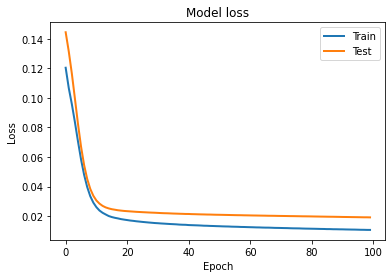

In [398]:
#plot the loss and validation loss of the model

plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

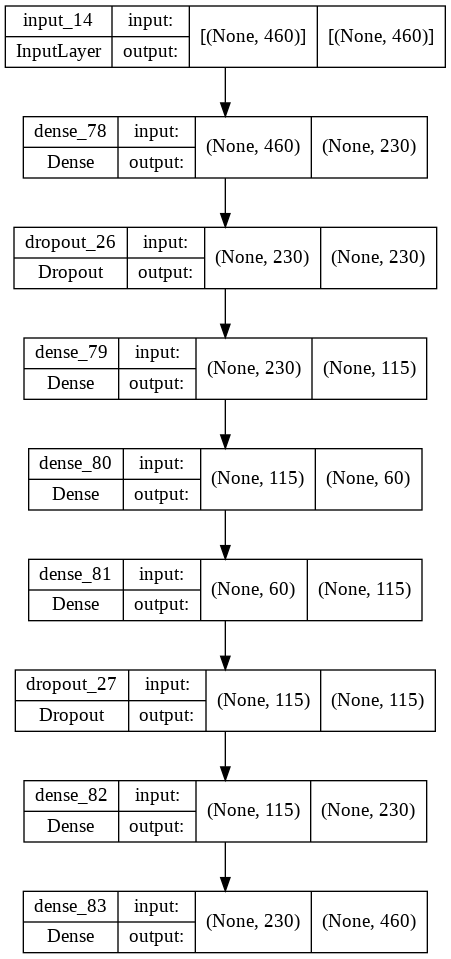

In [399]:
# plot the autoencoder

plot_model(autoencoder, 'autoencoder.png', show_shapes=True, show_layer_names=True)

## Reconstruction error check

In [400]:
#Checking the Reconstruction error loss

test_x_predictions=autoencoder.predict(normalized_test_X)
mse=np.mean(np.power(normalized_test_X-test_x_predictions,2),axis=1)

error=pd.DataFrame({'Reconstruction_error':mse,'True_class':y_test_})
error.head()

,Reconstruction_error,True_class
0,0.010840,0.0
1,0.035155,0.0
2,0.017753,0.0
3,0.017017,1.0
4,0.017265,0.0


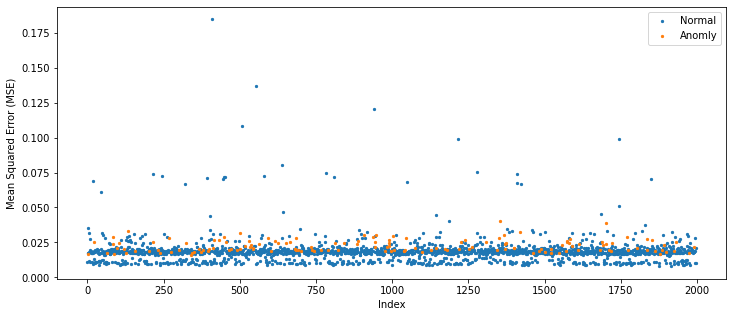

In [401]:
plt.figure(figsize=(12,5))
plt.scatter(error.index[error['True_class']==0],error[error['True_class']==0]['Reconstruction_error'],s=5,label='Normal')
plt.scatter(error.index[error['True_class']==1],error[error['True_class']==1]['Reconstruction_error'],s=5,label='Anomly')
plt.xlabel('Index')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

In [402]:
# Plotting the precision recall curve.

precision,recall,threshold=precision_recall_curve(error.True_class,error.Reconstruction_error)
f1_score=2*precision*recall/(precision+recall)
average_precision=average_precision_score(error.True_class,error.Reconstruction_error)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [403]:
#choosing the threshold to maximize the F1 score

max_f1=f1_score[f1_score==max(f1_score)]
best_threshold=threshold[f1_score[1: ]==max_f1]
print('best threshold',best_threshold)

best threshold [0.0225286]


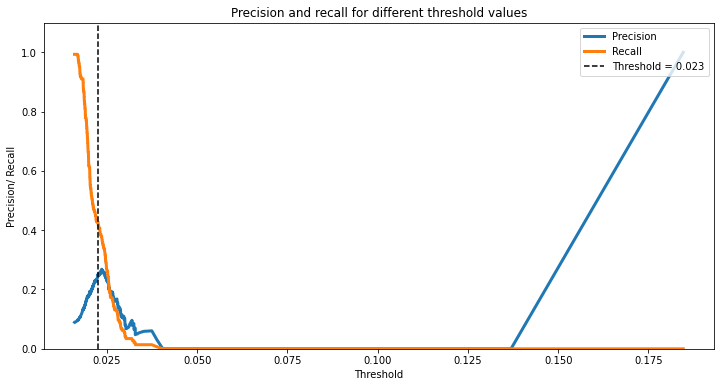

In [404]:
#Precision,Recall curve

plt.figure(figsize=(12,6))
plt.plot(threshold,precision[1: ],label='Precision',linewidth=3)
plt.plot(threshold, recall[1: ], label ="Recall", linewidth = 3)
plt.axvline(best_threshold, color = 'black', ls = '--', label = 'Threshold = %0.3f' % (best_threshold))
plt.ylim(0, 1.1)
plt.xlabel('Threshold')
plt.ylabel('Precision/ Recall')
plt.title('Precision and recall for different threshold values')
plt.legend(loc = 'upper right')

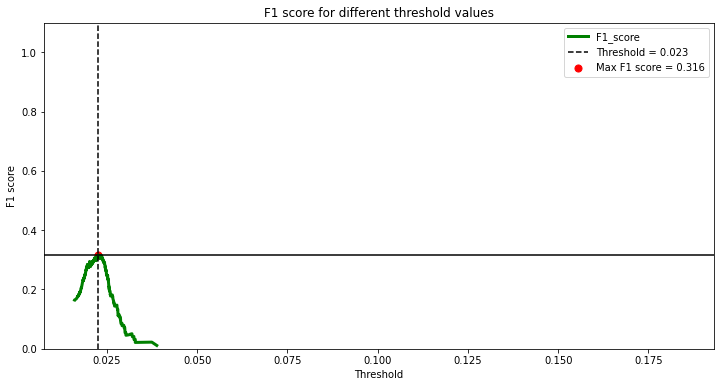

Best threshold = 0.022529
Max F1 score = 0.316327


In [405]:
#F1 score curve

plt.figure(figsize = (12, 6))
plt.plot(threshold, f1_score[1: ], label = "F1_score", linewidth = 3, color = 'green')
plt.scatter(threshold[f1_score[1: ] == max_f1], max_f1, label = 'Max F1 score = %0.3f' % (max_f1), s = 50, color = 'red')
plt.axvline(best_threshold, color = 'black', ls = '--', label = 'Threshold = %0.3f' % (best_threshold))
plt.axhline(max_f1, color = 'black', ls = '-')
plt.ylim(0, 1.1)
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.title('F1 score for different threshold values')
plt.legend(loc = 'upper right')
plt.show()
print('Best threshold = %f' % (best_threshold))
print('Max F1 score = %f' % (max_f1))

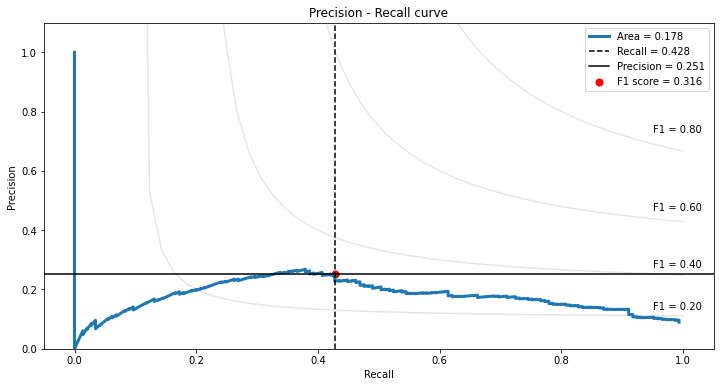

In [406]:
## Recall - Precision curve
plt.figure(figsize = (12, 6))
f_scores = np.linspace(0.2, 0.8, num = 4)

for f_score in f_scores:
    x = np.linspace(0.001, 1)
    y = f_score * x / (2 * x - f_score)
    plt.plot(x[y >= 0], y[y >= 0], color = 'gray', alpha = 0.2)
    plt.annotate('F1 = {0:0.2f}'.format(f_score), xy = (0.95, y[45] + 0.02))
plt.plot(recall[1: ], precision[1: ], label = 'Area = %0.3f' % (average_precision), linewidth = 3)
plt.scatter(recall[f1_score == max_f1], precision[f1_score == max_f1], label = 'F1 score = %0.3f' % (max_f1), s = 50, color = 'red')
plt.axvline(recall[f1_score == max_f1], color = 'black', ls = '--', label = 'Recall = %0.3f' % (recall[f1_score == max_f1]))
plt.axhline(precision[f1_score == max_f1], color = 'black', ls = '-', label = 'Precision = %0.3f' % (precision[f1_score == max_f1]))
plt.ylim(0, 1.1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - Recall curve')
plt.legend(loc = 'upper right')
plt.show()

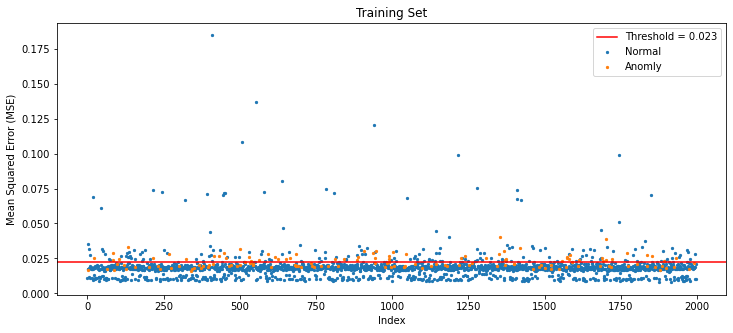

Best threshold = 0.022529


In [407]:
plt.figure(figsize = (12, 5))
plt.scatter(error.index[error['True_class'] == 0], error[error['True_class'] == 0]['Reconstruction_error'], s = 5, label = 'Normal')
plt.scatter(error.index[error['True_class'] == 1], error[error['True_class'] == 1]['Reconstruction_error'], s = 5, label = 'Anomly')
plt.axhline(best_threshold, color = 'red', label = 'Threshold = %0.3f' % (best_threshold))
plt.xlabel('Index')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training Set')
plt.legend()
plt.show()
print('Best threshold = %f' % (best_threshold))

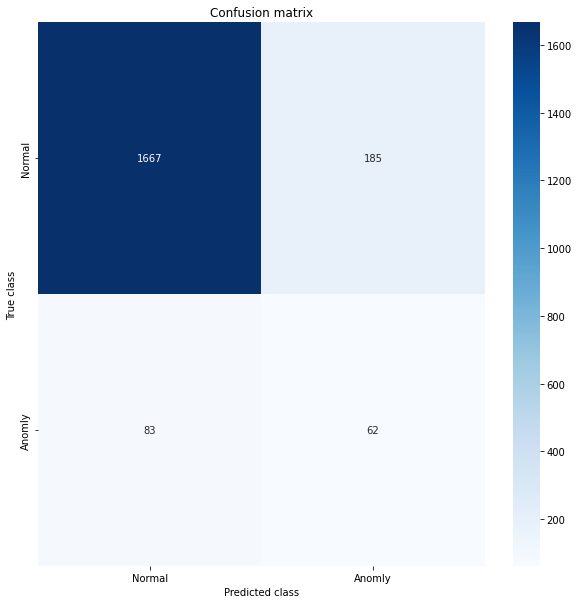

In [408]:
# if reconstruction error is greater than threshold it is Anomly 

pred_y = [1 if e > best_threshold  else 0 for e in error.Reconstruction_error.values]
error['pred'] =pred_y
conf_matrix = confusion_matrix(error.True_class, pred_y)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",cmap='Blues');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

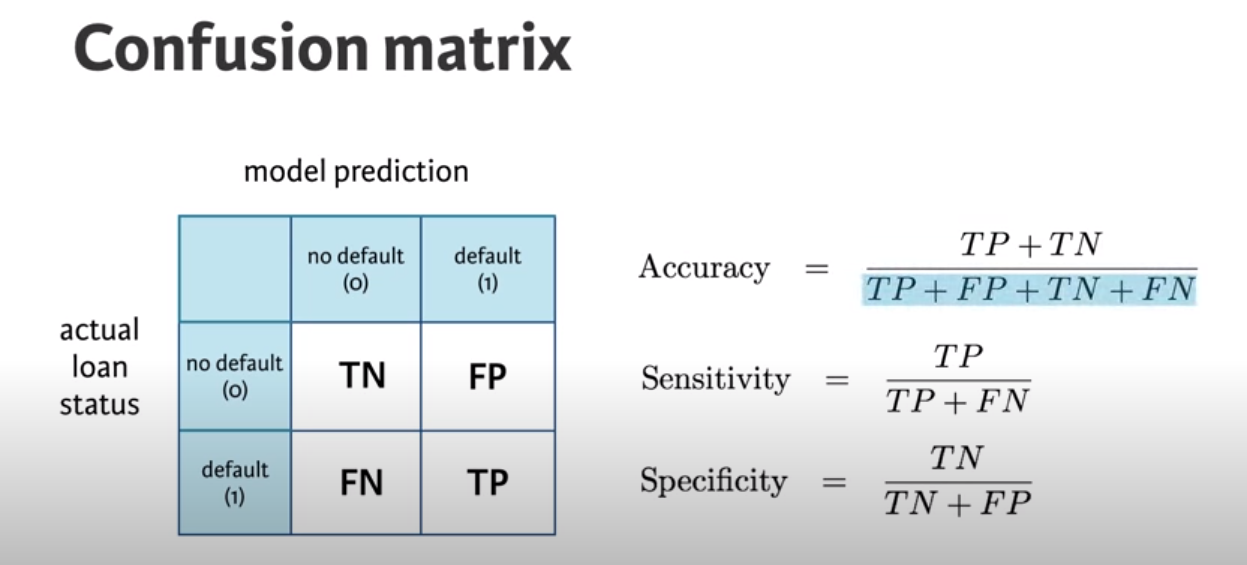

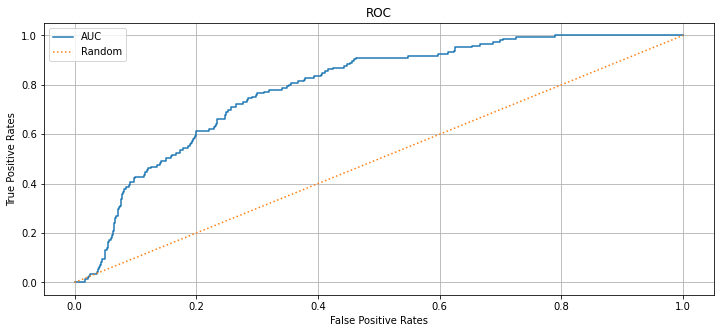

In [409]:
fpr, tpr, thres = roc_curve(error.True_class, error.Reconstruction_error)
plt.figure(figsize = (12, 5))
plt.plot(fpr, tpr, label = 'AUC') 
plt.plot([0,1], [0,1], ':', label = 'Random') 
plt.legend() 
plt.grid() 
plt.ylabel("True Positive Rates") 
plt.xlabel("False Positive Rates") 
plt.title('ROC') 
plt.show() 

In [410]:
# print Accuracy, precision and recall

print("Area under ROC : ", roc_auc_score(error['True_class'],error['pred'] ))
print(" Accuracy: ",accuracy_score(error['True_class'], error['pred']))
print(" Recall: ",recall_score(error['True_class'], error['pred']))
print(" Precision: ",precision_score(error['True_class'], error['pred']))

Area under ROC :  0.6638470991286214
 Accuracy:  0.8657986980470707
 Recall:  0.42758620689655175
 Precision:  0.25101214574898784


In [411]:
print(classification_report(y_test_,pred_y))

              precision    recall  f1-score   support

         0.0       0.95      0.90      0.93      1852
         1.0       0.25      0.43      0.32       145

    accuracy                           0.87      1997
   macro avg       0.60      0.66      0.62      1997
weighted avg       0.90      0.87      0.88      1997

